<a href="https://colab.research.google.com/github/noiravee/competition/blob/main/%EB%89%B4%EC%8A%A4_%ED%86%A0%ED%94%BD_%EB%B6%84%EB%A5%98%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from lightgbm import LGBMClassifier


from konlpy.tag import Mecab
from tqdm import tqdm_notebook
import string
import warnings

import re

In [2]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [3]:
 cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [4]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 450kB 31.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-07-19 02:05:54--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c2:513, 2406:da00:ff00::34cc:ea4a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=jXvZ9M%2Bg5Z%2F07wUTe80erUmCTHg%3D&Expires=1626662086&AWSAccessKeyId=AKIA6KOSE3

In [71]:
train      = pd.read_csv("/content/drive/MyDrive/open/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/open/test_data.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/open/topic_dict.csv")

In [72]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [73]:
print(train.shape)

(45654, 3)


# preprocessing

In [74]:
def remove_symbol(text):
  #텍스트에 포함되어 있는 특수 문자 제거
  doc=  re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…→》]', '', text)  
  return doc

cleaned_title_train= train['title'].apply(lambda x: remove_symbol(x))
cleaned_title_test= test['title'].apply(lambda x:remove_symbol(x))

cleaned_title_train


0                   인천핀란드 항공기 결항휴가철 여행객 분통
1            실리콘밸리 넘어서겠다구글 15조원 들여 美전역 거점화
2           이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3          NYT 클린턴 측근韓기업 특수관계 조명공과 사 맞물려종합
4                시진핑 트럼프에 중미 무역협상 조속 타결 희망
                       ...                
45649          KB금융 미국 IB 스티펠과 제휴선진국 시장 공략
45650      1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토
45651          게시판 키움증권 2020 키움 영웅전 실전투자대회
45652                    답변하는 배기동 국립중앙박물관장
45653    2020 한국인터넷기자상 시상식 내달 1일 개최특별상 김성후
Name: title, Length: 45654, dtype: object

In [75]:
def text_cleaning(text):
  mecab=Mecab()
  doc= ' '.join(mecab.morphs(text))
  return doc
    
cleaned_title_train= cleaned_title_train.astype(str)
cleaned_title_train= cleaned_title_train.apply(text_cleaning)


In [76]:
cleaned_title_train

0                     인천 핀란드 항공기 결항 휴가철 여행객 분통
1         실리콘밸리 넘어서 겠 다구 글 15 조 원 들여 美 전역 거점 화
2          이란 외무 긴장 완화 해결책 은 미국 이 경제 전쟁 멈추 는 것
3         NYT 클린턴 측근 韓 기업 특수 관계 조명 공과 사 맞물려 종합
4                  시진핑 트럼프 에 중미 무역 협상 조속 타결 희망
                         ...                  
45649           KB 금융 미국 IB 스티펠 과 제휴 선진국 시장 공략
45650    1 보 서울시 교육청 신종 코로나 확산 에 개학 연기 · 휴업 검토
45651            게시판 키움증권 2020 키움 영웅전 실전 투자 대회
45652                   답변 하 는 배기동 국립 중앙 박물 관장
45653    2020 한국 인터넷 기자상 시상식 내달 1 일 개최 특별상 김성후
Name: title, Length: 45654, dtype: object

In [78]:
data=train['title']
target= train['topic_idx']

In [77]:
train_list= cleaned_title_train.tolist()

In [81]:
ngram_range=(1,1)
min_df =2
max_df=20000
max_features=20000

In [82]:

tfidfv=TfidfVectorizer()
tfidfv.fit(train_list)
tfidfv_train= tfidfv.transform(train_list)



In [83]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val= train_test_split(tfidfv_train,target, test_size=0.2 , stratify=target, random_state=1234)

In [94]:
x_train, x_val, y_train, y_val= train_test_split(train_list,target, test_size=0.2 , stratify=target, random_state=1234)

# LGBM

In [ ]:
lgbm= LGBMClassifier(random_state=1234)

lgbm.fit(x_train, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred= lgbm.predict(x_val)
accuracy=accuracy_score(y_val, pred)

print(accuracy)

0.7720668759582391


In [ ]:
pred=lgbm.predict(tfidfv_test)

In [26]:
# 전처리 및 머신 러닝 알고리즘
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

# Randomforest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model  = RandomForestClassifier(random_state=1234)
model.fit(x_train, y_train)
pred = model.predict(x_val)


In [ ]:
accuracy=accuracy_score(y_val, pred)
print(accuracy)

0.7771044754325764


# LogisticRegression

In [ ]:
from sklearn.pipeline import Pipeline

pipeline= Pipeline([
                    ('tfidf_vect', TfidfVectorizer()),
                    ('LR', LogisticRegression())
])

params={'tfidf_vect__ngram_range':[(1,1),(1,2),(1,3)],
'tfidf_vect__min_df' :[1,2,3],
'tfidf_vect__max_df':[300,500,1000],
'tfidf_vect__max_features':[10000,20000],
'LR__C':[2]}

gridcv_pipe= GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1)
gridcv_pipe.fit(x_train, y_train)

print(gridcv_pipe.best_params_, gridcv_pipe.best_score_)

pred= gridcv_pipe.predict(x_val)
print(accuracy_score(y_val, pred))

In [ ]:
'LR__C': 2, 
'tfidf_vect__max_df': 1000, 
'tfidf_vect__max_features': 20000, 
'tfidf_vect__min_df': 2, 
'tfidf_vect__ngram_range': (1, 1)} 
0.8264928466507824
0.8299200525681744

In [84]:

model = LogisticRegression(C=2)
print(model.get_params())
model.fit(x_train, y_train)
pred= model.predict(x_val)

{'C': 2, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [85]:
accuracy=accuracy_score(y_val, pred)
print(accuracy)

0.8363815573321651


In [86]:
predict=model.predict(tfidfv_test)

In [61]:
param_grid = {'C': [1,2,3,4]
    # Create a list of options for the regularization penalty
    }
clf = GridSearchCV(model, param_grid, cv = 3, verbose = 1)

bestF = clf.fit(x_train, y_train)
bestF.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

{'C': 2}

In [62]:
model = LogisticRegression(C=2)
model.fit(x_train, y_train)
model_predictions = model.predict(x_val)
print('Accuracy: ', accuracy_score(y_val, model_predictions))


Accuracy:  0.8363815573321651


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
model = KNeighborsClassifier()
model.fit(x_train, y_train)
model_predictions = model.predict(x_val)
print('Accuracy: ', accuracy_score(y_val, model_predictions))


Accuracy:  0.22574286340074468


In [42]:
model = XGBClassifier(random_state=1234)

model.fit(x_train, y_train)
model_predictions = model.predict(x_val)
print('Accuracy: ', accuracy_score(y_val, model_predictions))


Accuracy:  0.6759391085313766


In [43]:
model = AdaBoostClassifier(random_state=1234)

model.fit(x_train, y_train)
model_predictions = model.predict(x_val)
print('Accuracy: ', accuracy_score(y_val, model_predictions))


Accuracy:  0.4807797612528748


In [95]:
model = GaussianNB()

model.fit(x_train, y_train)
model_predictions = model.predict(x_val)
print('Accuracy: ', accuracy_score(y_val, model_predictions))


ValueError: ignored

# model fitting

In [ ]:
ran = RandomForestClassifier(random_state=1234)
log = LogisticRegression()
xgb = XGBClassifier(random_state=1234)
svc = SVC(probability=True)
ext = ExtraTreesClassifier(random_state=1234)
gpc = GaussianProcessClassifier()
bag = BaggingClassifier(random_state=1234)

In [ ]:
# 리스트 준비
models = [ran, log, xgb]         
model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']
scores2 = {}

# 학습 및 교차 검증
for ind, mod in enumerate(models):
    print(mod)
    mod.fit(x_train, y_train)
    acc = cross_val_score(mod, x_train, y_train, scoring = "accuracy", cv = 5)
    scores2[model_names[ind]] = acc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


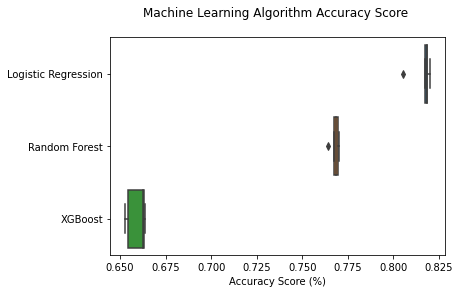

In [ ]:
import seaborn as sns
results = pd.DataFrame(scores2).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)#.reset_index()
result_df.head(11)
result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)');

In [ ]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparams = {'penalty': penalty, 'C': C}

gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


0.8164724368925403
{'C': 2.7825594022071245, 'penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [63]:
model = LogisticRegression(C=2)
model.fit(x_train, y_train)
model_predictions = model.predict(x_val)
print('Accuracy: ', accuracy_score(y_val, model_predictions))

Accuracy:  0.8363815573321651


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
bag = BaggingClassifier(random_state=1)
bag.fit(x_train, y_train)
model_predictions = bag.predict(x_val)
print('Accuracy: ', accuracy_score(y_val, model_predictions))

Accuracy:  0.7360735927575381


# Prediction

In [87]:

    
cleaned_title_test= cleaned_title_test.astype(str)
cleaned_title_test= cleaned_title_test.apply(text_cleaning)
test_list= cleaned_title_test.tolist()

In [88]:

tfidfv_test= tfidfv.transform(test_list)

In [89]:
pred= model.predict(tfidfv_test)


In [90]:
submission=pd.read_csv("/content/drive/MyDrive/open/sample_submission.csv")
submission['topic_idx']=pred
submission.head()

,index,topic_idx
0,45654,3
1,45655,3
2,45656,1
3,45657,2
4,45658,3


In [91]:
submission=pd.read_csv("/content/drive/MyDrive/open/sample_submission.csv")
submission['topic_idx']=pred
submission.head()

,index,topic_idx
0,45654,3
1,45655,3
2,45656,1
3,45657,2
4,45658,3


In [92]:
submission.to_csv('submission15.csv' ,index= False)

# doc2vec


In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


In [ ]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []

    
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    
    return labeled

In [ ]:
x_train, x_test= train_test_split(cleaned_title_train, test_size=0.3, random_state=1234)

In [ ]:
x_train

39291        中 제재 품목 北 철광석 수입 사드 영향 분석
34883         이스트 스프링 올해 골디락스 위험 자산 양호
7513         윤관석 중도금 대출 보증금 액 보증 사고 급증
25415        지역 사회 문화 거점 부산 도서관 년 월 개관
16602              이달 편집상 경향신문 오늘 명 퇴근
                     ...              
32399    유엔 일본 지도자 공직자 위안부 폄하 발언 중단 종합
17048              체류 北 노동자 명 전원 본국 송환
23924                     기기 착용 콘텐츠 제작
34086         中 시진핑 솔로몬 제도 총리 하나 중국 강조
27439            모바일 프리미엄 규격 확정 갤 인증 듯
Name: title, Length: 31957, dtype: object

In [ ]:
x_train = label_sentences(x_train, 'train')
x_test = label_sentences(x_test, 'test')

In [ ]:
all_data = x_train+ x_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 45654/45654 [00:00<00:00, 1837490.81it/s]


In [ ]:
import numpy as np
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(x_train), 300, 'train')
test_vectors_dbow = get_vectors(model_dbow, len(x_test), 300, 'test')

In [ ]:
y_train

16387    5
29836    1
21380    4
33719    4
19326    4
        ..
24391    5
21860    6
3570     6
30230    6
2324     1
Name: topic_idx, Length: 31957, dtype: int64

In [ ]:
model2 = LogisticRegression(n_jobs=1, C=1e5)
model2= model2.fit(train_vectors_dbow, y_train)
model_prediction = model2.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_val))


accuracy 0.1528801927429364


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
